In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

/root/workdir/fourier_learning_ibm


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
# GPU check
!nvidia-smi -L

GPU 0: NVIDIA A100-PCIE-40GB (UUID: GPU-3fac7503-bb55-35cd-f566-c919eaa55798)
GPU 1: NVIDIA A100-PCIE-40GB (UUID: GPU-bf03abcd-ef36-6733-da57-460c8eb9cab4)
GPU 2: NVIDIA A100-PCIE-40GB (UUID: GPU-bc01f8f3-0939-f2c0-6998-dd49d0360463)
GPU 3: NVIDIA A100-PCIE-40GB (UUID: GPU-b7aeac00-b332-1045-eebc-bb5653ac8402)


In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import time
from heisenberg import (
    HeisenbergModel,
    get_graph,
    get_positions,
)
from calc_expected_value import calculate_expected_value
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import SparsePauliOp, Statevector
import networkx as nx
import cupy as cp

In [6]:
import warnings

warnings.filterwarnings("ignore")

In [8]:
n_qubits = 52
n_samples = 5
beta = 1.0

### Check graph (i.e., Heisenberg Hamiltonian)

今回用いるハミルトニアンは、開放境界条件の 1 次元ハイゼンベルグ模型 : 

\begin{aligned}
H=\sum_{i=0}^{n-2} J_i\left(X_i X_{i+1}+Y_i Y_{i+1}+Z_i Z_{i+1}\right)
\end{aligned}

相互作用強度 $J_i$ は $[-1, 1]$ の一様分布からランダムに選ぶ。

これを networkx のグラフとして表す。

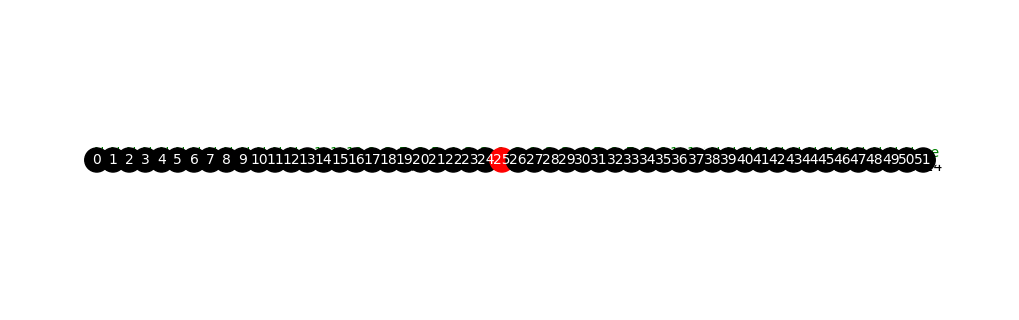

In [9]:
rng = np.random.default_rng(42)

# -1 から 1 の一様乱数で Js を生成。その後 sum(|Js|) = 1 になるように正規化
Js = rng.uniform(-1, 1, size=n_qubits - 1)
Js /= np.sum(np.abs(Js))

G = get_graph(n_qubits, Js)
positions = get_positions(n_qubits)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

上の図で、
- 丸はスピンを表し、量子回路を実行するときには量子ビットとしてマップされる
- 赤い丸は、GHZ 部分の最初にアダマールゲートが作用する量子ビットである
- エッジの緑の数字は、GHZ 部分で CNOT が作用する順番である。効率的にエンタングルメントが広がるように、アダマールゲートが作用した量子ゲートから順に CNOT をかけていく。GHZ 部分で用意したい状態は $\ket{00111100}$ (中心半分が 1) なので、CNOT が作用する量子ビットは中心の半分である。'None' はそれ以外、つまり CNOT が作用されず、0 のままであることを表す
- エッジの黒の数字は、相互作用強度 $J_{ij}$ を表す。「ランダムなハミルトニアンを作る」とは、これらの $J_{ij}$ をランダムに作ることを意味する。

## データセットの作成

教師あり学習用のデータセット、すなわち input と output が組になったデータセットを作る。

input: Hamiltonian $H$

output: $y(H)=\operatorname{Tr}[f(H)\rho]$

今回は
- $f(H)=e^{-\beta H}$
- $\rho$ は純粋状態 $\rho=\ket{\psi}\bra{\psi}, \ket{\psi}=\ket{0011\cdots1100}$ (真ん中半分が 1, それ以外は 0)

とする。すなわち

output: $y(H)=\bra{\psi} e^{-\beta H} \ket{\psi}$

となる。以下ではまず、$\ket{\psi}=\ket{0011\cdots1100}$ を作成する。

次に、$y(H)=\bra{\psi} e^{-\beta H} \ket{\psi}$ を虚時間 TEBD で計算してデータセットを作る。12 量子ビット以下は厳密対角化と比較して、虚時間 TEBD の結果が合っているか確かめる。

In [10]:
data = []
rng = np.random.default_rng(42)

for i in range(n_samples):
    print(f"Sample {i}/{n_samples}")

    # -1 から 1 の一様乱数で Js を生成。その後 sum(|Js|) = 1 になるように正規化
    Js = rng.uniform(-1, 1, size=n_qubits - 1)
    Js /= np.sum(np.abs(Js))

    expected_value_tebd, expected_value_diag, diff = calculate_expected_value(
        n_qubits, Js
    )
    data.append(
        {
            "sample": i,
            "Js": Js,
            "expected_value": expected_value_tebd,
            "expected_value_diag": expected_value_diag,
            "diff": diff,
        }
    )

df = pd.DataFrame(data)
print(f"diff mean: {df['diff'].mean():.3e}")
print(
    "Note: The expected value is calculated by TEBD. \nFor small number of qubits, to check the accuracy, the expected value is also calculated by diagonalizing the Hamiltonian."
)
display(df)
df["expected_value"].describe()

# json に保存 (orient="records" で行ごとに保存)
df.to_json(
    f"results/get_dataset/{n_qubits}Q/dataset.json",
    orient="records",
    indent=4,
)

Sample 0/5
Elapsed time for TEBD: 13.24[s]

Sample 1/5
Elapsed time for TEBD: 13.14[s]

Sample 2/5
Elapsed time for TEBD: 13.13[s]

Sample 3/5
Elapsed time for TEBD: 13.20[s]

Sample 4/5
Elapsed time for TEBD: 13.19[s]

diff mean: nan
Note: The expected value is calculated by TEBD. 
For small number of qubits, to check the accuracy, the expected value is also calculated by diagonalizing the Hamiltonian.


,sample,Js,expected_value,expected_value_diag,diff
0,0,"[0.021581075342385653, -0.0048148927673179855,...",0.874333,None,None
1,1,"[-0.042483157666652595, 0.024743239949706175, ...",1.264982,None,None
2,2,"[-0.019849499249864726, 0.03977668225859758, 0...",1.043115,None,None
3,3,"[0.0038696408259075213, -0.028030706729807606,...",0.878768,None,None
4,4,"[-0.038509265037774625, -0.021418483480388665,...",0.920255,None,None


## ノルムが 3 以下になっているか確認

ノルムを求めるのは、量子ビット数が多くなってくると難しくなる。なのでこのセクションは少ない量子ビット数でのみ実行可能。

In [ ]:
for i in range(n_samples):
    Js = df["Js"].values[i]
    G = get_graph(n_qubits, Js)
    heisenberg = HeisenbergModel(n_qubits, G)
    H = heisenberg.get_hamiltonian()
    # norm = scipy.sparse.linalg.norm(H.to_matrix(sparse=True), ord=2)

    # norm を cupy で計算
    norm = cp.linalg.norm(cp.asarray(H.to_matrix()), ord=2)

    print(f"Js: {Js}, norm: {norm:.3e}")

Js: [ 0.09544193 -0.02129378  0.12492982  0.06875989 -0.14138216  0.16569927
  0.09097692  0.09966026 -0.1295593  -0.01728475 -0.04501192], norm: 1.725e+00
Js: [ 0.16564625  0.05584038  0.12527797 -0.02196344 -0.10587064  0.02118676
 -0.1693017   0.12716806  0.05110474  0.1001752  -0.05646487], norm: 1.834e+00
Js: [ 0.14041277  0.11727099  0.0830439  -0.09109158 -0.00992738 -0.13608678
 -0.10312805  0.05460488  0.0730144   0.13946168 -0.05195761], norm: 1.610e+00
Js: [-0.06194496 -0.01455813 -0.1484919  -0.17696808 -0.01161768 -0.1305894
  0.08120347 -0.03005337  0.15908361  0.0957649  -0.08972452], norm: 1.793e+00
Js: [ 0.11249199  0.10318295 -0.03809603 -0.07166498  0.06178684 -0.12196769
 -0.10160098 -0.16679056  0.09714294  0.05581295  0.06946209], norm: 1.516e+00
Js: [ 0.15157608 -0.02218291  0.03711594 -0.19448704 -0.2081296   0.09092704
 -0.01560624  0.03522341  0.14308277  0.07273945  0.02892952], norm: 1.700e+00
Js: [ 0.02233565 -0.073959   -0.17699699 -0.0238731  -0.10767173 

### (付録) 量子ビットを増やした時の TEBD と厳密対角化の比較

In [18]:
n_qubits_list = [4, 8, 12, 20, 40, 60, 80, 100]
expected_values_tebd = []
expected_values_diag = []
diffs = []
rng = np.random.default_rng(42)
n_qubits_diag_upper_bound = 12

for n_qubits in n_qubits_list:
    print(f"processing for {n_qubits} qubits...")

    # -1 から 1 の一様乱数で Js を生成。その後 sum(|Js|) = 1 になるように正規化
    Js = rng.uniform(-1, 1, size=n_qubits - 1)
    Js /= np.sum(np.abs(Js))

    expected_value_tebd, expected_value_diag, diff = calculate_expected_value(
        n_qubits, Js
    )
    expected_values_tebd.append(expected_value_tebd)
    expected_values_diag.append(expected_value_diag)
    diffs.append(diff)

df = pd.DataFrame(
    {
        "n_qubits": n_qubits_list,
        "expected_value_tebd": expected_values_tebd,
        "expected_value_diag": expected_values_diag,
        "diff": diffs,
    }
)
display(df)

processing for 4 qubits...


Elapsed time for TEBD: 0.93[s]
Elapsed time for diagonalization: 0.00[s]

processing for 8 qubits...
Elapsed time for TEBD: 2.11[s]
Elapsed time for diagonalization: 0.00[s]

processing for 12 qubits...
Elapsed time for TEBD: 3.19[s]
Elapsed time for diagonalization: 0.43[s]

processing for 20 qubits...
Elapsed time for TEBD: 5.16[s]

processing for 40 qubits...
Elapsed time for TEBD: 10.01[s]

processing for 60 qubits...
Elapsed time for TEBD: 14.91[s]

processing for 80 qubits...
Elapsed time for TEBD: 19.81[s]

processing for 100 qubits...
Elapsed time for TEBD: 24.81[s]



,n_qubits,expected_value_tebd,expected_value_diag,diff
0,4,5.547457,5.547451,5.591330e-06
1,8,0.457030,0.457030,4.929879e-09
2,12,1.111247,1.111247,3.868749e-07
3,20,0.853209,NaN,NaN
4,40,1.034675,NaN,NaN
5,60,1.109520,NaN,NaN
6,80,1.061310,NaN,NaN
7,100,1.127011,NaN,NaN
